In [51]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.cm as cm
from pathlib import Path


# Use the parent directory of this file for results
# results_dir = os.getcwd()
results_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250920"
data_dir = os.path.join(results_dir, "data")
plot_dir = os.path.join(results_dir, "plots")

print(f"Results directory: {results_dir}")
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


morphseq_root = os.environ.get('MORPHSEQ_REPO_ROOT')
morphseq_root = "/net/trapnell/vol1/home/mdcolon/proj/morphseq"
print(f"MORPHSEQ_REPO_ROOT: {morphseq_root}")
os.chdir(morphseq_root)

from src.functions.embryo_df_performance_metrics import *
from src.functions.spline_morph_spline_metrics import *



Results directory: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250920
MORPHSEQ_REPO_ROOT: /net/trapnell/vol1/home/mdcolon/proj/morphseq


In [52]:
# Import TZ experiments
experiments =  ["20230615","20230531", "20230525"] + ["20250912","20250711"]

build06_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output"

# Load all experiments
dfs = []
for exp in experiments:
    try:
        file_path = f"{build06_dir}/df03_final_output_with_latents_{exp}.csv"
        df = pd.read_csv(file_path)
        df['source_experiment'] = exp
        print(df['genotype'].value_counts())
        dfs.append(df)
        print(f"Loaded {exp}: {len(df)} rows")
    except:
        print(f"Missing: {exp}")

# Combine all data
combined_df = pd.concat(dfs, ignore_index=True)
# print(f"\nTotal: {len(combined_df)} rows from {len(dfs)} experiments")

# # Save combined data
# combined_df.to_csv(os.path.join(data_dir, "Titration_experiments_combined_20250912_20250711.csv"), index=False)

# combined_df = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250919/data/Titration_experiments_combined_20250912_20250711.csv")

genotype
wik    2772
Name: count, dtype: int64
Loaded 20230615: 2772 rows
genotype
wik    3631
Name: count, dtype: int64
Loaded 20230531: 3631 rows
genotype
wik    2805
Name: count, dtype: int64
Loaded 20230525: 2805 rows
genotype
wik-ab    2093
Name: count, dtype: int64
Loaded 20250912: 2093 rows
genotype
tmem67_heterozygote    3010
tmem67_homozygous      2762
tmem67_wildtype        2142
Name: count, dtype: int64
Loaded 20250711: 7914 rows


In [53]:
# # Subset to 5k random rows where master_perturbation = 'wt' and rename column
# # First, let's see what values are available in short_pert_name

# embryo_stats_df_file = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250917/data/embryo_stats_df.csv"

# embryo_stats_df = pd.read_csv(embryo_stats_df_file)

# # Filter to wt (wild-type) rows
# wt_rows = embryo_stats_df[embryo_stats_df['short_pert_name'] == 'wt_wik'].copy()
# print(f"\nTotal wt rows available: {len(wt_rows)}")

# wt_rows.loc[wt_rows['short_pert_name'] == "wt_wik", 'short_pert_name'] = "wik"


# # Sample 6k random rows (or all if less than 6k available)
# n_sample = min(6000, len(wt_rows))
# wt_subset = wt_rows.sample(n=n_sample, random_state=42)

# # Rename master_perturbation column to genotype
# wt_subset = wt_subset.rename(columns={'short_pert_name': 'genotype'})

# print(f"Created subset with {len(wt_subset)} rows")
# print(f"New column 'genotype' values: {wt_subset['genotype'].unique()}")

# # Show first few rows to verify
# print("\nFirst 5 rows of subset:")
# print(wt_subset[['experiment_date', 'genotype']].head())

In [54]:
# Merge wt_subset with combined_df
# combined_df = pd.concat([combined_df, wt_subset], ignore_index=True)
# print(f"After merging: {len(combined_df)} total rows")
print(f"Genotype distribution: {combined_df['genotype'].value_counts()}")

Genotype distribution: genotype
wik                    9208
tmem67_heterozygote    3010
tmem67_homozygous      2762
tmem67_wildtype        2142
wik-ab                 2093
Name: count, dtype: int64


In [55]:
# Create new combined column
combined_df['chem_n_genotype'] = combined_df['chem_perturbation'].astype(str) + '_' + combined_df['genotype'].astype(str)

combined_df.chem_n_genotype.value_counts()

chem_n_genotype
nan_wik                    9208
nan_tmem67_heterozygote    3010
nan_tmem67_homozygous      2762
nan_tmem67_wildtype        2142
tri_1-25_wik-ab             542
tri_1-30_wik-ab             415
tri_1-40_wik-ab             393
tri_1-35_wik-ab             286
tri_1-20_wik-ab             268
tri_1-15_wik-ab             130
tri_0_wik-ab                 59
Name: count, dtype: int64

In [56]:
# Use only z_mu_b columns and filter out bad rows by experiment
z_mu_cols = [col for col in combined_df.columns if col.startswith('z_mu_b_')]
print(f"Found {len(z_mu_cols)} z_mu_b columns")

# Check NaN values by experiment
print("\nNaN analysis by experiment:")
for exp in combined_df['source_experiment'].unique():
    exp_data = combined_df[combined_df['source_experiment'] == exp]
    rows_with_nan = exp_data[z_mu_cols].isnull().any(axis=1)
    print(f"{exp}: {rows_with_nan.sum()} NaN rows out of {len(exp_data)} total ({rows_with_nan.sum()/len(exp_data)*100:.1f}%)")

# Overall NaN check
rows_with_nan = combined_df[z_mu_cols].isnull().any(axis=1)
print(f"\nOverall: {rows_with_nan.sum()} NaN rows out of {len(combined_df)} total")

# Filter out rows with NaN values
clean_df = combined_df[~rows_with_nan].copy()
print(f"After cleaning: {len(clean_df)} rows remaining")

# Show remaining data by experiment
print("\nRemaining data by experiment:")
for exp in clean_df['source_experiment'].unique():
    exp_count = len(clean_df[clean_df['source_experiment'] == exp])
    print(f"{exp}: {exp_count} rows")

# Update combined_df to be the clean version
combined_df = clean_df

Found 80 z_mu_b columns

NaN analysis by experiment:
20230615: 0 NaN rows out of 2772 total (0.0%)
20230531: 0 NaN rows out of 3631 total (0.0%)
20230525: 0 NaN rows out of 2805 total (0.0%)
20250912: 141 NaN rows out of 2093 total (6.7%)
20250711: 0 NaN rows out of 7914 total (0.0%)

Overall: 141 NaN rows out of 19215 total
After cleaning: 19074 rows remaining

Remaining data by experiment:
20230615: 2772 rows
20230531: 3631 rows
20230525: 2805 rows
20250912: 1952 rows
20250711: 7914 rows


In [57]:
combined_df.chem_n_genotype.value_counts()

chem_n_genotype
nan_wik                    9208
nan_tmem67_heterozygote    3010
nan_tmem67_homozygous      2762
nan_tmem67_wildtype        2142
tri_1-25_wik-ab             448
tri_1-30_wik-ab             415
tri_1-40_wik-ab             388
tri_1-35_wik-ab             286
tri_1-20_wik-ab             246
tri_1-15_wik-ab             130
tri_0_wik-ab                 39
Name: count, dtype: int64

In [58]:
combined_df = add_pca_components(combined_df, n_components=3)

pert_splines, df_augmented, segment_info_df = build_splines_and_segments(
    df=combined_df,
    model_index=74,
    LocalPrincipalCurveClass=LocalPrincipalCurve,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50,
    save_dir=data_dir,
    group_by_col="chem_n_genotype",
)

Building spline data for each chem_n_genotype...


Creating splines for each chem_n_genotype: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.96it/s]


Spline DataFrame 'pert_splines' saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250920/data/pert_splines_74_unique.csv
Assigning segments and building segment_info_df...


Processing chem_n_genotype:   9%|██████████████▎                                                                                                                                              | 1/11 [00:01<00:10,  1.08s/it]/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning:

The covariance matrix associated to your dataset is not full rank

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning:

The covariance matrix associated to your dataset is not full rank

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning:

The covariance matrix associated to your dataset is not full rank

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-pac

In [59]:
def plot_pca_with_splines(df_points, df_splines, 
                         point_opacity=0.7, 
                         save_dir=None, 
                         downsample_dict=None, 
                         color_dict=None,
                         title="PCA Plot with Splines",
                         min_snip_count=20,
                         phenotypes_of_interest=None,
                         show_splines=True,
                         spline_width=6,
                         group_by_col='genotype',
                         filename=None,
                         color_by=None,  # New parameter for coloring by continuous variable
                         colorscale='viridis'):  # Colorscale for continuous variables
    """Plot PCA points and their splines with customizable options."""
    import plotly.graph_objects as go
    import plotly.express as px
    import os
    
    # Filter by phenotypes of interest first
    if phenotypes_of_interest is not None:
        df_points = df_points[df_points[group_by_col].isin(phenotypes_of_interest)].copy()
        if df_splines is not None:
            df_splines = df_splines[df_splines[group_by_col].isin(phenotypes_of_interest)].copy()
    
    # Filter embryos based on snip count
    embryo_counts = df_points.groupby('embryo_id')['snip_id'].count()
    valid_embryos = embryo_counts[embryo_counts >= min_snip_count].index.tolist()
    
    # Filter out embryos with too few snips
    removed_embryos = set(df_points['embryo_id'].unique()) - set(valid_embryos)
    if removed_embryos:
        print(f"Removed {len(removed_embryos)} embryos with fewer than {min_snip_count} snips.")
    
    # Filter dataframe to include only valid embryos
    filtered_df = df_points[df_points['embryo_id'].isin(valid_embryos)].copy()
    
    # Check if any data remains after filtering
    if filtered_df.empty:
        print("Warning: No data remaining after filtering.")
        fig = go.Figure()
        fig.update_layout(title="No Data Available")
        return fig
    
    # Get unique phenotypes (after filtering)
    phenotypes = filtered_df[group_by_col].unique()
    
    # Create figure
    fig = go.Figure()
    
    # If color_by is specified, color by continuous variable
    if color_by is not None and color_by in filtered_df.columns:
        print(f"Coloring points by {color_by}")
        
        # FIXED: Calculate global color range across ALL data going into plot
        global_min = filtered_df[color_by].min()
        global_max = filtered_df[color_by].max()
        print(f"Global {color_by} range: {global_min:.2f} to {global_max:.2f}")
        
        # Process each phenotype separately to maintain grouping
        for phenotype in phenotypes:
            # Filter points for this phenotype
            points = filtered_df[filtered_df[group_by_col] == phenotype].copy()
            
            # Apply downsampling if specified
            if downsample_dict is not None and phenotype in downsample_dict:
                fraction = downsample_dict[phenotype]
                if 0 < fraction < 1:
                    points = points.sample(frac=fraction, random_state=42)
            
            # FIXED: Create consistent hover text with all information
            hover_text = []
            for _, row in points.iterrows():
                hover_info = (
                    f"<b>{group_by_col.title()}: {row[group_by_col]}</b><br>"
                    f"Embryo ID: {row['embryo_id']}<br>"
                    f"Snip ID: {row['snip_id']}<br>"
                    f"Predicted Stage (hpf): {row['predicted_stage_hpf']:.2f}<br>"
                    f"PCA_1: {row['PCA_1']:.3f}<br>"
                    f"PCA_2: {row['PCA_2']:.3f}<br>"
                    f"PCA_3: {row['PCA_3']:.3f}<br>"
                    f"{color_by}: {row[color_by]:.2f}"
                )
                hover_text.append(hover_info)
            
            # Add points to plot with GLOBAL color scale
            fig.add_trace(
                go.Scatter3d(
                    x=points['PCA_1'],
                    y=points['PCA_2'],
                    z=points['PCA_3'],
                    mode='markers',
                    marker=dict(
                        size=4,
                        color=points[color_by],
                        colorscale=colorscale,
                        opacity=point_opacity,
                        showscale=True,
                        colorbar=dict(title=color_by),
                        cmin=global_min,  # FIXED: Set global color range
                        cmax=global_max   # FIXED: Set global color range
                    ),
                    name=f"{phenotype}",
                    showlegend=True,
                    hovertemplate='%{text}<extra></extra>',
                    text=hover_text
                )
            )
            
            # Add spline for this phenotype
            if show_splines and df_splines is not None:
                spline = df_splines[df_splines[group_by_col] == phenotype]
                if not spline.empty:
                    # Use a solid color for splines when coloring by continuous variable
                    spline_color = px.colors.qualitative.Plotly[list(phenotypes).index(phenotype) % len(px.colors.qualitative.Plotly)]
                    fig.add_trace(
                        go.Scatter3d(
                            x=spline['PCA_1'],
                            y=spline['PCA_2'],
                            z=spline['PCA_3'],
                            mode='lines',
                            line=dict(
                                color=spline_color,
                                width=spline_width
                            ),
                            name=f"{phenotype} (spline)",
                            showlegend=True
                        )
                    )
    
    else:
        # Original behavior: color by group_by_col
        # Create color dictionary if not provided
        if color_dict is None:
            default_colors = [
                '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
            ]
            color_dict = {phenotype: default_colors[i % len(default_colors)] for i, phenotype in enumerate(phenotypes)}
        
        # Process each phenotype
        for phenotype in phenotypes:
            # Filter points for this phenotype
            points = filtered_df[filtered_df[group_by_col] == phenotype].copy()
            
            # Apply downsampling if specified
            if downsample_dict is not None and phenotype in downsample_dict:
                fraction = downsample_dict[phenotype]
                if 0 < fraction < 1:
                    points = points.sample(frac=fraction, random_state=42)
            
            # Get color for this phenotype
            color = color_dict.get(phenotype, '#1f77b4')
            
            # FIXED: Create consistent hover text with all information
            hover_text = []
            for _, row in points.iterrows():
                hover_info = (
                    f"<b>{group_by_col.title()}: {row[group_by_col]}</b><br>"
                    f"Embryo ID: {row['embryo_id']}<br>"
                    f"Snip ID: {row['snip_id']}<br>"
                    f"Predicted Stage (hpf): {row['predicted_stage_hpf']:.2f}<br>"
                    f"PCA_1: {row['PCA_1']:.3f}<br>"
                    f"PCA_2: {row['PCA_2']:.3f}<br>"
                    f"PCA_3: {row['PCA_3']:.3f}"
                )
                hover_text.append(hover_info)
            
            # Add points to plot
            fig.add_trace(
                go.Scatter3d(
                    x=points['PCA_1'],
                    y=points['PCA_2'],
                    z=points['PCA_3'],
                    mode='markers',
                    marker=dict(
                        size=4,
                        color=color,
                        opacity=point_opacity
                    ),
                    name=f"{phenotype} (points)",
                    showlegend=True,
                    hovertemplate='%{text}<extra></extra>',
                    text=hover_text
                )
            )
            
            # Add spline for this phenotype
            if show_splines and df_splines is not None:
                spline = df_splines[df_splines[group_by_col] == phenotype]
                if not spline.empty:
                    fig.add_trace(
                        go.Scatter3d(
                            x=spline['PCA_1'],
                            y=spline['PCA_2'],
                            z=spline['PCA_3'],
                            mode='lines',
                            line=dict(
                                color=color,
                                width=spline_width
                            ),
                            name=f"{phenotype} (spline)",
                            showlegend=True
                        )
                    )
    
    # Update layout
    fig.update_layout(
        scene=dict(
            xaxis_title='PCA 1',
            yaxis_title='PCA 2',
            zaxis_title='PCA 3'
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            x=0.01,
            y=0.99,
            bordercolor="Black",
            borderwidth=1
        )
    )
    
    # Save figure if save_dir is provided
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # Use custom filename if provided, otherwise default to title-based name
        if filename is not None:
            save_filename = filename if filename.endswith('.html') else f"{filename}.html"
        else:
            save_filename = f"{title.replace(' ', '_')}.html"
            
        save_path = os.path.join(save_dir, save_filename)
        fig.write_html(save_path)
        print(f"Plot saved to: {save_path}")
    
    return fig


In [60]:
# Now use the plot function with the splines data
# Create color dictionary for all genotypes with auto-scaling palette
import plotly.express as px

genotypes = combined_df['chem_n_genotype'].unique().tolist()
print(f"Found {len(genotypes)} chem_n_genotype: {genotypes}")

# Generate enough colors for all genotypes
if len(genotypes) <= len(px.colors.qualitative.Plotly):
    colors = px.colors.qualitative.Plotly[:len(genotypes)]
else:
    # If we need more colors, cycle through multiple palettes
    all_colors = (px.colors.qualitative.Plotly + 
                  px.colors.qualitative.Set1 + 
                  px.colors.qualitative.Set2)
    colors = all_colors[:len(genotypes)]

color_dict = {genotype: colors[i] for i, genotype in enumerate(genotypes)}
print(f"Generated color palette for {len(color_dict)} genotypes")

# Create the plot with splines colored by genotype (original)
fig1 = plot_pca_with_splines(
    df_points=df_augmented,
    df_splines=pert_splines,
    point_opacity=0.65,
    color_dict=color_dict,
    save_dir=plot_dir,
    title="Titration Experiments with Splines by Genotype",
    phenotypes_of_interest=genotypes,  # Use all genotypes instead of top 6
    show_splines=True,
    spline_width=15,
    min_snip_count=10,  # Lower threshold for TZ data
    group_by_col='chem_n_genotype',  # Specify we're using genotype column
    filename='titration_chem_n_genotype_splines_plot_20251006'  # Custom filename
)

# Create a second plot colored by predicted_stage_hpf
fig2 = plot_pca_with_splines(
    df_points=df_augmented,
    df_splines=pert_splines,
    point_opacity=0.65,
    save_dir=plot_dir,
    title="Titration Experiments Colored by Developmental Stage",
    phenotypes_of_interest=genotypes,  # Use all genotypes
    show_splines=True,
    spline_width=15,
    min_snip_count=10,
    group_by_col='chem_n_genotype',
    color_by='predicted_stage_hpf',  # Color by developmental stage
    colorscale='plasma',  # Different colorscale
    filename='titration_chem_n_stage_colored_plot_20251006'
)

# fig1.show()
# fig2.show()
print(f"Created plots with all {len(genotypes)} genotypes and saved to {plot_dir}")

Found 11 chem_n_genotype: ['nan_wik', 'tri_1-15_wik-ab', 'tri_1-20_wik-ab', 'tri_1-25_wik-ab', 'tri_1-30_wik-ab', 'tri_1-35_wik-ab', 'tri_1-40_wik-ab', 'tri_0_wik-ab', 'nan_tmem67_heterozygote', 'nan_tmem67_homozygous', 'nan_tmem67_wildtype']
Generated color palette for 11 genotypes
Removed 50 embryos with fewer than 10 snips.
Plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250920/plots/titration_chem_n_genotype_splines_plot_20251006.html
Removed 50 embryos with fewer than 10 snips.
Coloring points by predicted_stage_hpf
Global predicted_stage_hpf range: 7.00 to 127.40
Plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250920/plots/titration_chem_n_stage_colored_plot_20251006.html
Created plots with all 11 genotypes and saved to /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250920/plots


# evaluating flag occurance in tricane titration experiment

> so i did an experimentt where i changed the
  ititration of tricane and imaged for a
  long time. I hypothesized that higher
  levels would cause death but no moviement,
  low levels would cause less death but worse
  quality due to higher movement, we use the
  tricane to keep themebryos still for
  imaging )and in methyl celllaose), I want
  to look at the trends of the flags
  throughout the experiemnt for all te
  embryos.  



In [61]:
# Import TZ experiments
experiments = ["20250912","20250711"]

build04_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build04_output"

# Load all experiments
dfs = []
for exp in experiments:
    try:
        file_path = f"{build04_dir}/qc_staged_{exp}.csv"
        df = pd.read_csv(file_path)
        df['source_experiment'] = exp
        dfs.append(df)
        print(f"Loaded {exp}: {len(df)} rows")
    except:
        print(f"Missing: {exp}")

# Combine all data
qc_staged_df = pd.concat(dfs, ignore_index=True)
print(f"\nTotal: {len(qc_staged_df)} rows from {len(dfs)} experiments")

qc_staged_df['chem_n_genotype'] = qc_staged_df['chem_perturbation'].astype(str) + '_' + qc_staged_df['genotype'].astype(str)

# Save combined data
qc_staged_df.to_csv(os.path.join(data_dir, "qc_staged_Titration_experiments_combined_20250912_20250711.csv"), index=False)

Loaded 20250912: 11978 rows
Loaded 20250711: 16647 rows

Total: 28625 rows from 2 experiments


  first we will look at the dead flag, and
  look at it on  a per embryo bassis over
  predicted stge_hpf, coloring by
  chem_n_genotype AND THEN Ffinally the
  average percent of the dead_flag overtime
  to look at gross trinds, plot this in
  plotly so i can see indivudal embryo_ids as
  i hover over them.

In [62]:
# Filter data for tricaine analysis including wildtype control
# print("Original data shape:", qc_staged_df.shape)
# print("Unique chem_n_genotype values:", qc_staged_df['nan-w'].unique())

# # Filter to include tricaine concentrations + wildtype tmem67 as control
# tricane_conditions = qc_staged_df['chem_perturbation'].str.startswith('tri_', na=False)
# wildtype_control = qc_staged_df['chem_n_genotype'] == 'nan_tmem67_wildtype'

# filtered_df = qc_staged_df[tricane_conditions | wildtype_control].copy()

# print(f"\nFiltered data shape: {filtered_df.shape}")
# print("Conditions included:")
# print(df_augmented_projec_wt['chem_n_genotype'].value_counts().sort_index())

# print(df_augmented_projec_wt['chem_n_genotype'].unique())

In [63]:
def plot_hypotenuse_over_stage(
    df,
    group_by_col='phenotype',
    groups_to_include=None,
    window_size=5,
    figsize=(12, 8),
    palette="tab10",
    alpha=0.5,
    plot_individual_embryos=True,
    plot_average=True,
    plot_variance_bars=False,
    central_tendency='median',
    highlight_embryos=None,
    max_hpf=None,
    min_hpf=None,
    max_distance=None,
    min_points_per_embryo=5,
    save_path=None,
    show_legend=True,
    title=None,
    group_colors=None,
    title_fontsize=16,
    label_fontsize=14,
    tick_fontsize=12,
    legend_fontsize=12
):
    """
    Plot hypotenuse (distance from spline) over predicted stage with smoothing.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data, must have columns:
        ['hypotenuse', 'embryo_id', 'predicted_stage_hpf'] and the column specified by group_col
    group_by_col : str, default='phenotype'
        Name of the column to use for grouping (e.g., 'phenotype', 'treatment', 'condition')
    groups_to_include : list, optional
        List of groups to include in the plot. If None, all groups are included.
    window_size : int, default=5
        Window size for rolling average smoothing.
    figsize : tuple, default=(12, 8)
        Figure size (width, height) in inches.
    palette : str or dict, default="tab10"
        Color palette name or dict mapping groups to colors.
    alpha : float, default=0.5
        Transparency level for individual embryo lines.
    plot_individual_embryos : bool, default=True
        Whether to plot individual embryo traces.
    plot_average : bool, default=True
        Whether to plot average line per group.
    plot_variance_bars : bool, default=False
        Whether to plot standard error bars around the average lines.
        For mean: plots ±SEM. For median: plots 25th-75th percentile range.
    central_tendency : str, default='mean'
        Measure of central tendency to use for group averages.
        Options: 'mean' or 'median'.
    highlight_embryos : list, optional
        List of embryo_ids to highlight with thicker lines.
    max_hpf : float, optional
        Maximum hours post-fertilization to include in the plot.
    min_hpf : float, optional
        Minimum hours post-fertilization to include in the plot.
    max_distance : float, optional
        Maximum distance (hypotenuse) value for y-axis limit.
    min_points_per_embryo : int, default=5
        Minimum number of data points required for an embryo to be included.
    save_path : str, optional
        Path to save the figure, if provided.
    show_legend : bool, default=True
        Whether to show the legend.
    title : str, optional
        Plot title. If None, a default title is used.
    group_colors : dict, optional
        Dictionary mapping group names to colors. Overrides palette.
        Example: {'homo': 'green', 'wt': 'blue', 'het': 'orange'}
    title_fontsize : int, default=16
        Font size for the plot title.
    label_fontsize : int, default=14
        Font size for axis labels (x and y labels).
    tick_fontsize : int, default=12
        Font size for axis tick labels.
    legend_fontsize : int, default=12
        Font size for legend text.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    # Validate central_tendency parameter
    if central_tendency not in ['mean', 'median']:
        raise ValueError("central_tendency must be either 'mean' or 'median'")
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure required columns exist
    required_cols = ['hypotenuse', 'embryo_id', 'predicted_stage_hpf', group_by_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Filter by group if specified
    if groups_to_include is not None:
        df = df[df[group_by_col].isin(groups_to_include)]
    
    # Filter by hpf range if specified
    if max_hpf is not None:
        df = df[df['predicted_stage_hpf'] <= max_hpf]
    if min_hpf is not None:
        df = df[df['predicted_stage_hpf'] >= min_hpf]
    
    # Filter embryos with too few data points
    embryo_counts = df.groupby('embryo_id').size()
    valid_embryos = embryo_counts[embryo_counts >= min_points_per_embryo].index
    df = df[df['embryo_id'].isin(valid_embryos)]
    
    # If DataFrame is empty after filtering, return empty plot
    if df.empty:
        plt.figure(figsize=figsize)
        plt.text(0.5, 0.5, "No data available after filtering", 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=14)
        plt.gca().set_axis_off()
        return plt.gcf()
    
    # Setup figure
    plt.figure(figsize=figsize)
    
    # Get unique groups and assign colors
    unique_groups = df[group_by_col].unique()
    
    # Use custom group_colors if provided, otherwise use palette
    if group_colors is not None:
        color_mapping = group_colors
    elif isinstance(palette, str):
        color_palette = sns.color_palette(palette, n_colors=len(unique_groups))
        color_mapping = {group: color_palette[i] for i, group in enumerate(unique_groups)}
    else:
        # If palette is a dict, use it directly
        color_mapping = palette
    
    # Store lines for legend
    group_lines = {}
    highlight_lines = {}
    
    # Plot individual embryos
    if plot_individual_embryos:
        for embryo_id, group_data in df.groupby('embryo_id'):
            group_value = group_data[group_by_col].iloc[0]
            color = color_mapping.get(group_value, 'gray')
            
            # Sort by predicted_stage_hpf
            group_data = group_data.sort_values('predicted_stage_hpf')
            
            # Apply smoothing with rolling window
            group_data['smooth_hypotenuse'] = group_data['hypotenuse'].rolling(
                window=window_size, min_periods=1, center=True
            ).mean()
            
            # Determine line properties
            is_highlight = highlight_embryos is not None and embryo_id in highlight_embryos
            line_alpha = 1.0 if is_highlight else alpha
            line_width = 2.5 if is_highlight else 1
            
            # Plot the line
            line = plt.plot(
                group_data['predicted_stage_hpf'], 
                group_data['smooth_hypotenuse'], 
                color=color, 
                alpha=line_alpha,
                linewidth=line_width,
                label=None  # We'll add to legend separately
            )
            
            # Store for legend if this is a highlight
            if is_highlight:
                highlight_lines[embryo_id] = line[0]
    
    # Plot average line per group
    if plot_average:
        for group_value, group_data in df.groupby(group_by_col):
            color = color_mapping.get(group_value, 'gray')
            
            # Group by predicted_stage_hpf bins (0.5 hour increments)
            group_data['stage_bin'] = (group_data['predicted_stage_hpf'] * 2).astype(int) / 2
            
            # Calculate statistics per bin based on central_tendency
            if central_tendency == 'mean':
                # Calculate mean and standard error per bin
                stage_stats = group_data.groupby('stage_bin')['hypotenuse'].agg(['mean', 'std', 'sem', 'count']).reset_index()
                stage_stats = stage_stats[stage_stats['count'] > 0]  # Remove bins with no data
                
                # Sort by stage
                stage_stats = stage_stats.sort_values('stage_bin')
                
                # Apply smoothing to mean
                stage_stats['smooth_central'] = stage_stats['mean'].rolling(
                    window=window_size, min_periods=1, center=True
                ).mean()
                
                # Calculate smoothed SEM
                stage_stats['smooth_lower'] = stage_stats['sem'].rolling(
                    window=window_size, min_periods=1, center=True
                ).mean()
                stage_stats['smooth_upper'] = stage_stats['smooth_lower'].copy()
                
            else:  # median
                # Calculate median and percentiles per bin
                def percentile_25(x):
                    return np.percentile(x, 25)
                def percentile_75(x):
                    return np.percentile(x, 75)
                
                stage_stats = group_data.groupby('stage_bin')['hypotenuse'].agg([
                    ('median', 'median'),
                    ('p25', percentile_25),
                    ('p75', percentile_75),
                    ('count', 'count')
                ]).reset_index()
                stage_stats = stage_stats[stage_stats['count'] > 0]  # Remove bins with no data
                
                # Sort by stage
                stage_stats = stage_stats.sort_values('stage_bin')
                
                # Apply smoothing to median
                stage_stats['smooth_central'] = stage_stats['median'].rolling(
                    window=window_size, min_periods=1, center=True
                ).mean()
                
                # Apply smoothing to percentiles separately
                stage_stats['smooth_p25'] = stage_stats['p25'].rolling(
                    window=window_size, min_periods=1, center=True
                ).mean()
                stage_stats['smooth_p75'] = stage_stats['p75'].rolling(
                    window=window_size, min_periods=1, center=True
                ).mean()
                
                # For consistency with error bar plotting, store as deviations
                stage_stats['smooth_lower'] = stage_stats['smooth_central'] - stage_stats['smooth_p25']
                stage_stats['smooth_upper'] = stage_stats['smooth_p75'] - stage_stats['smooth_central']
            
            # Plot average line
            tendency_label = f" [{central_tendency}]" if central_tendency == 'median' else ""
            line = plt.plot(
                stage_stats['stage_bin'], 
                stage_stats['smooth_central'], 
                color=color, 
                linewidth=5,
                label=f"{group_value} (n={len(group_data['embryo_id'].unique())}){tendency_label}"
            )
            
            # Plot variance bars if requested
            if plot_variance_bars:
                if central_tendency == 'mean':
                    plt.fill_between(
                        stage_stats['stage_bin'],
                        stage_stats['smooth_central'] - stage_stats['smooth_lower'],
                        stage_stats['smooth_central'] + stage_stats['smooth_upper'],
                        color=color,
                        alpha=0.2
                    )
                else:  # median - plot actual percentile ranges
                    plt.fill_between(
                        stage_stats['stage_bin'],
                        stage_stats['smooth_p25'],
                        stage_stats['smooth_p75'],
                        color=color,
                        alpha=0.2
                    )
            
            # Store for legend
            group_lines[group_value] = line[0]
    
    # Set title and labels
    title = title or "Distance from Spline by Developmental Stage"
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel('Predicted Stage (hpf)', fontsize=label_fontsize)
    plt.ylabel('Distance from Spline (Hypotenuse)', fontsize=label_fontsize)
    
    # Set tick label font sizes
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    # Set axis limits
    if max_distance is not None:
        plt.ylim(top=max_distance)
    
    if min_hpf is not None or max_hpf is not None:
        current_xlim = plt.xlim()
        new_xlim = (
            min_hpf if min_hpf is not None else current_xlim[0],
            max_hpf if max_hpf is not None else current_xlim[1]
        )
        plt.xlim(new_xlim)
    
    # Add legend
    if show_legend:
        # Add group legend
        if plot_average and group_lines:
            legend_labels = []
            legend_handles = []
            
            for group_value in group_lines.keys():
                n_embryos = len(df[df[group_by_col]==group_value]['embryo_id'].unique())
                tendency_label = f" [{central_tendency}]" if central_tendency == 'median' else ""
                if plot_variance_bars:
                    if central_tendency == 'mean':
                        legend_labels.append(f"{group_value} (n={n_embryos}){tendency_label} ±SE")
                    else:
                        legend_labels.append(f"{group_value} (n={n_embryos}){tendency_label} (IQR)")
                else:
                    legend_labels.append(f"{group_value} (n={n_embryos}){tendency_label}")
                legend_handles.append(group_lines[group_value])
            
            plt.legend(
                handles=legend_handles,
                labels=legend_labels,
                title=group_by_col.replace('_', ' ').title(),
                loc="upper left",
                fontsize=legend_fontsize,
                title_fontsize=legend_fontsize
            )
        
        # Add highlight legend
        if highlight_embryos and highlight_lines:
            if plot_average:  # Add a separate legend for highlights if we already have one for groups
                plt.legend(
                    handles=list(highlight_lines.values()),
                    labels=list(highlight_lines.keys()),
                    title="Highlighted Embryos",
                    loc="upper right",
                    fontsize=legend_fontsize,
                    title_fontsize=legend_fontsize
                )
            else:  # Otherwise combine them
                all_lines = {**group_lines, **highlight_lines}
                all_labels = list(group_lines.keys()) + list(highlight_lines.keys())
                plt.legend(
                    handles=list(all_lines.values()),
                    labels=all_labels,
                    loc="best",
                    fontsize=legend_fontsize,
                    title_fontsize=legend_fontsize
                )
    
    # Set grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()

In [64]:
wt_splines_n_planes = segment_info_df[segment_info_df["chem_n_genotype"] == "nan_wik"]

# A) Points from "wt" itself
# wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
df_points = project_points_onto_reference_spline(
    df_augmented,
    wt_splines_n_planes
)

df_augmented_projec_wt = pd.merge(
    df_augmented, 
    df_points.drop(columns=[col for col in df_points.columns if col in df_augmented.columns and col != "snip_id"]),
    on="snip_id"
)

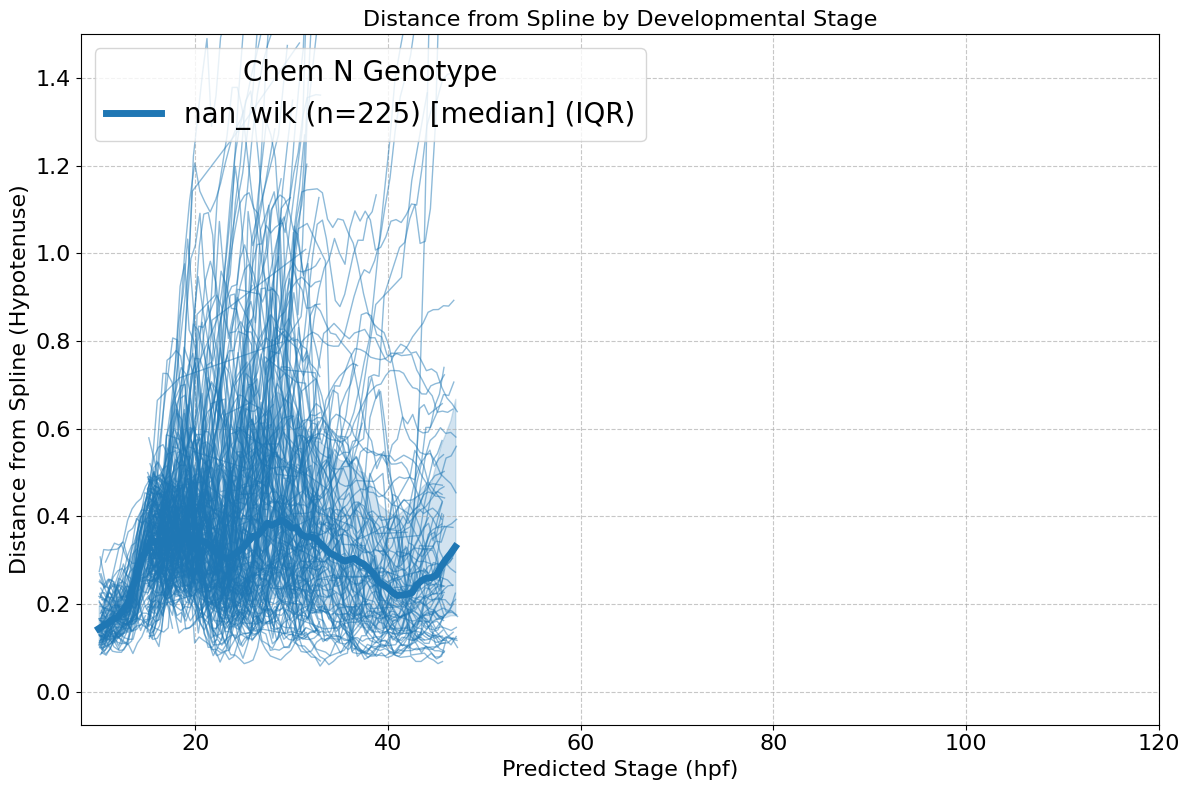

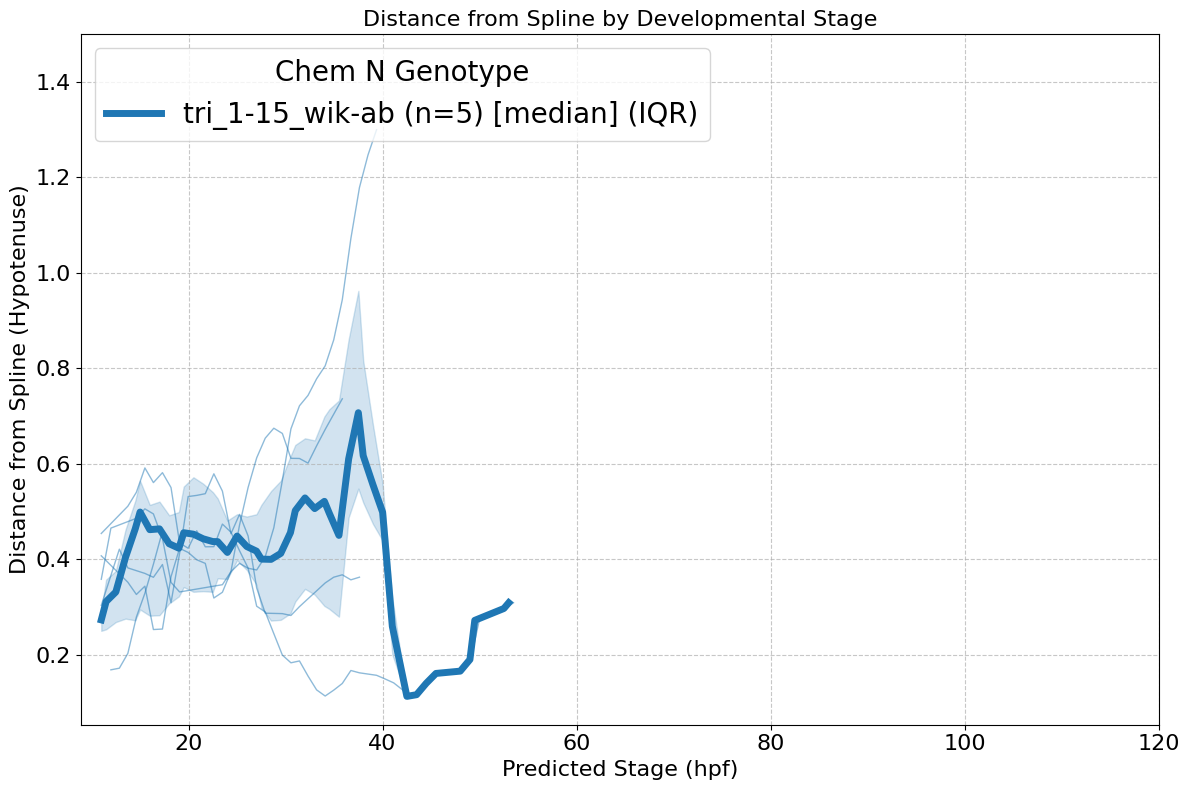

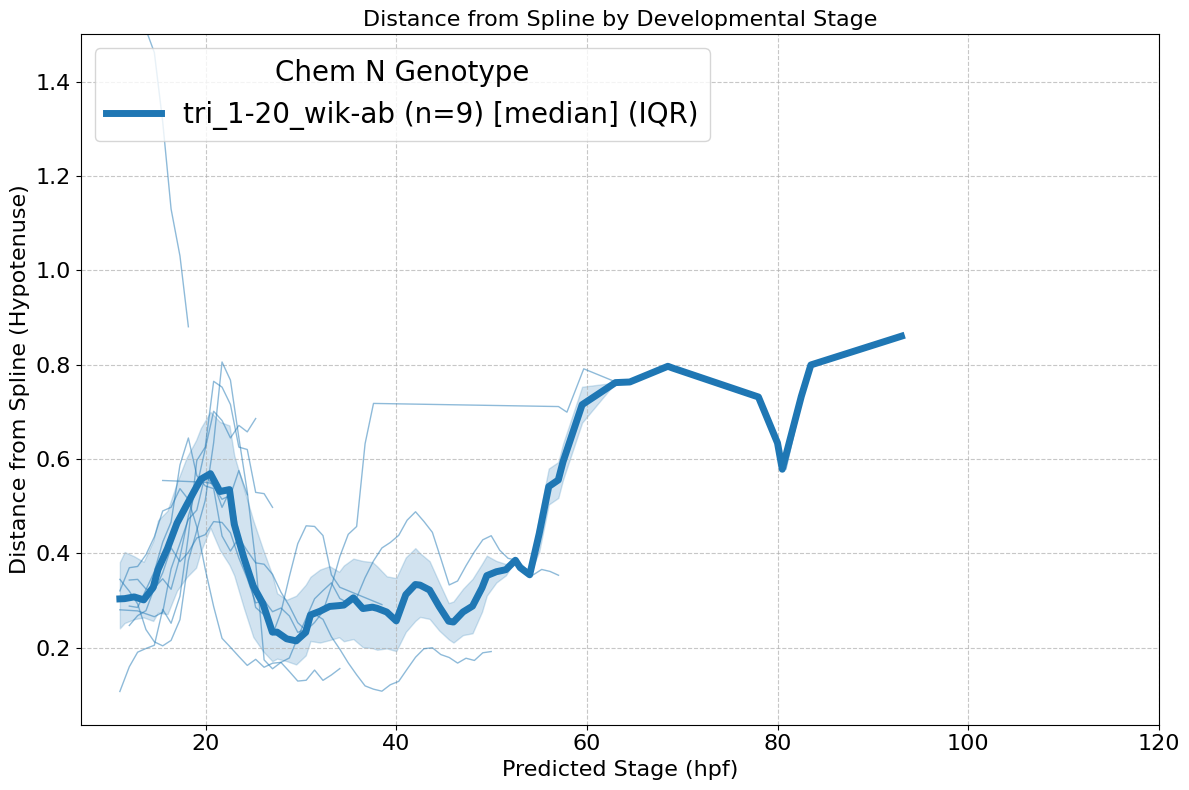

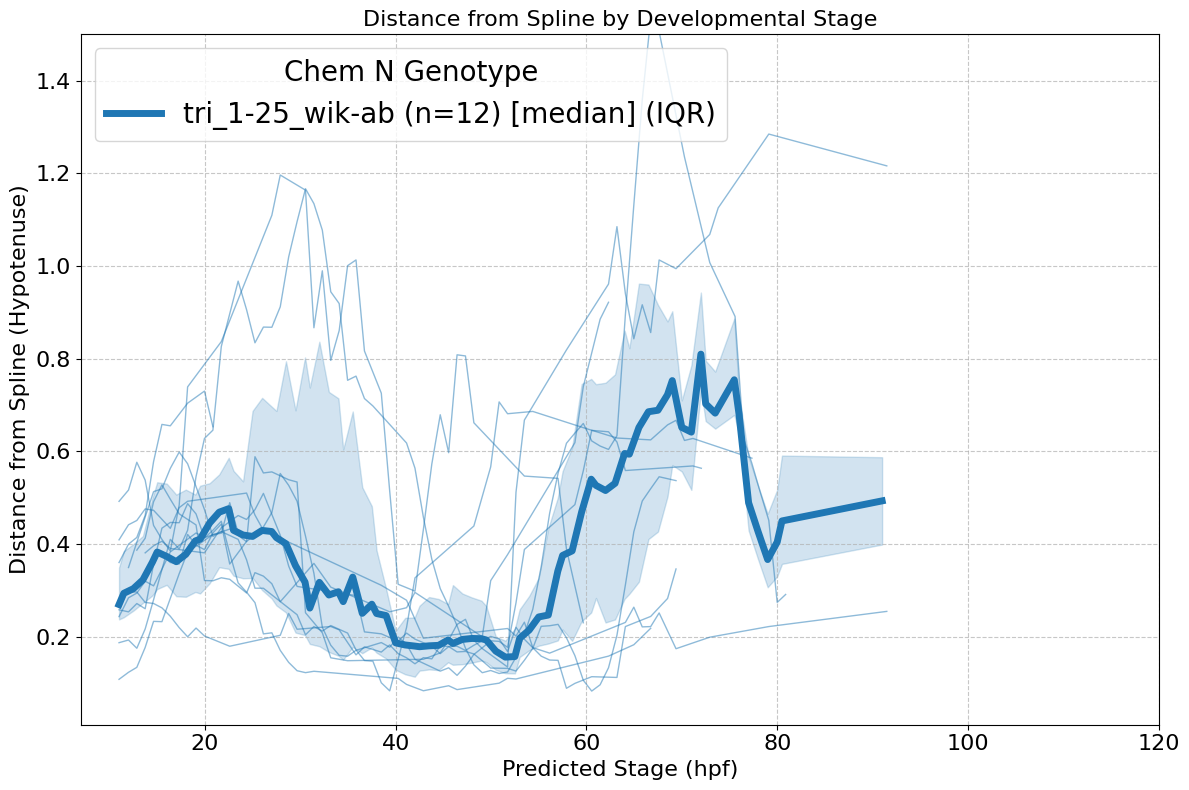

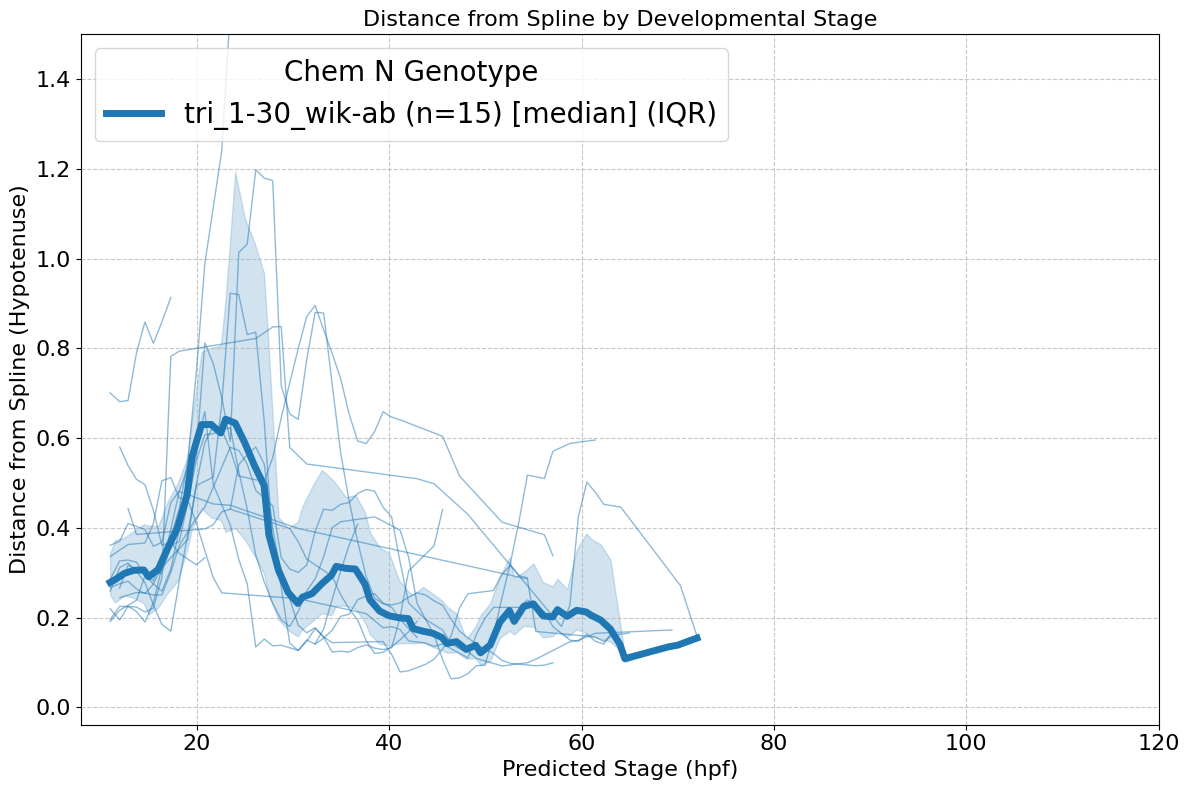

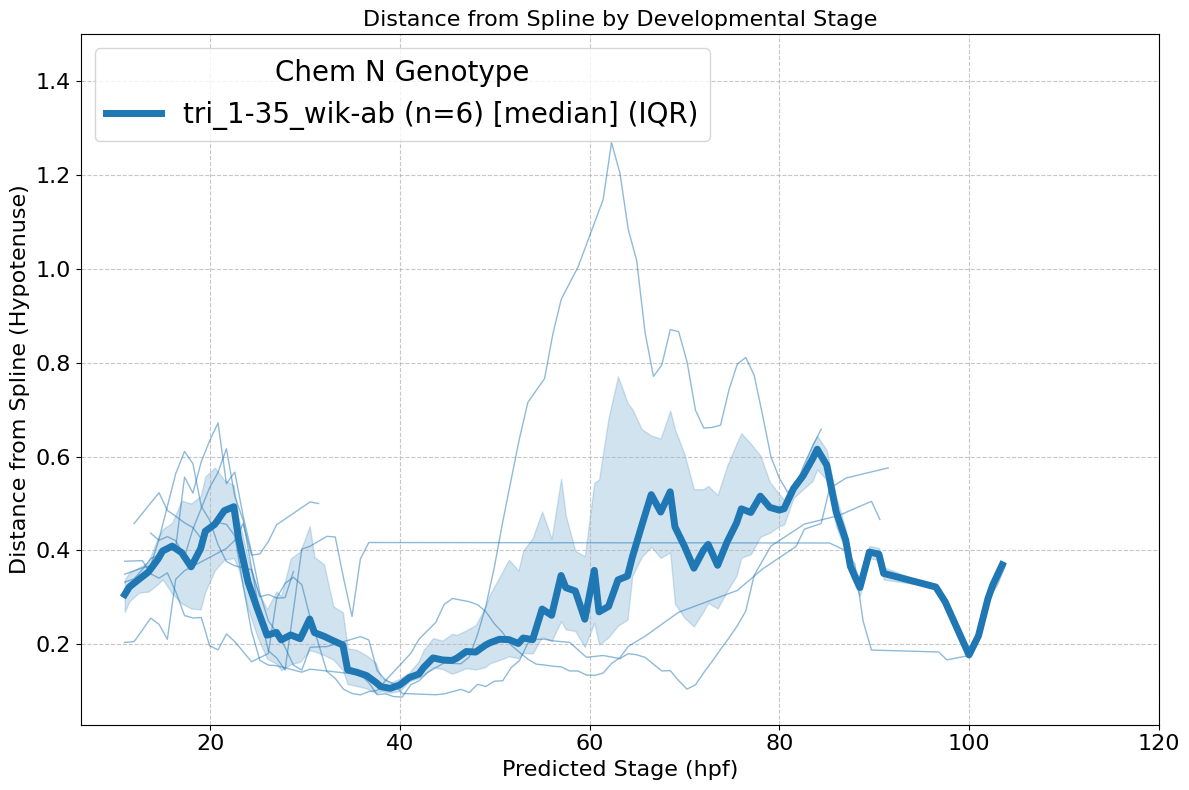

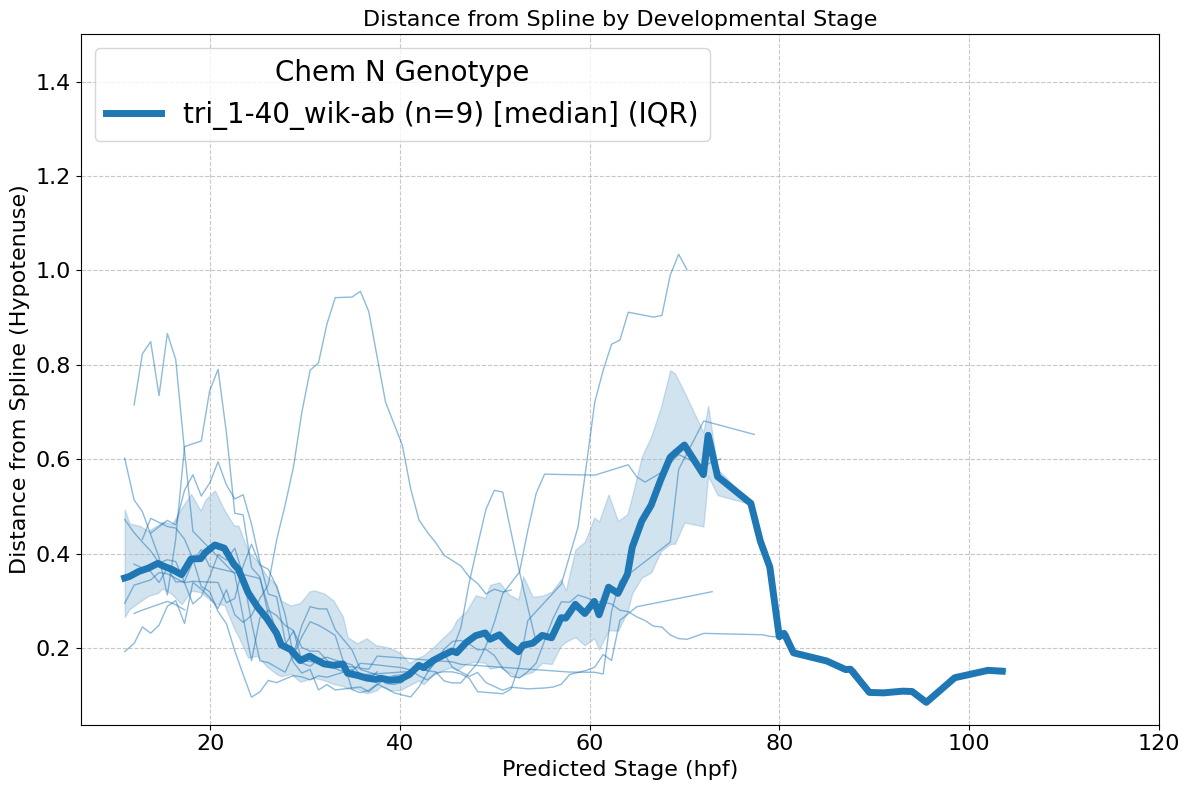

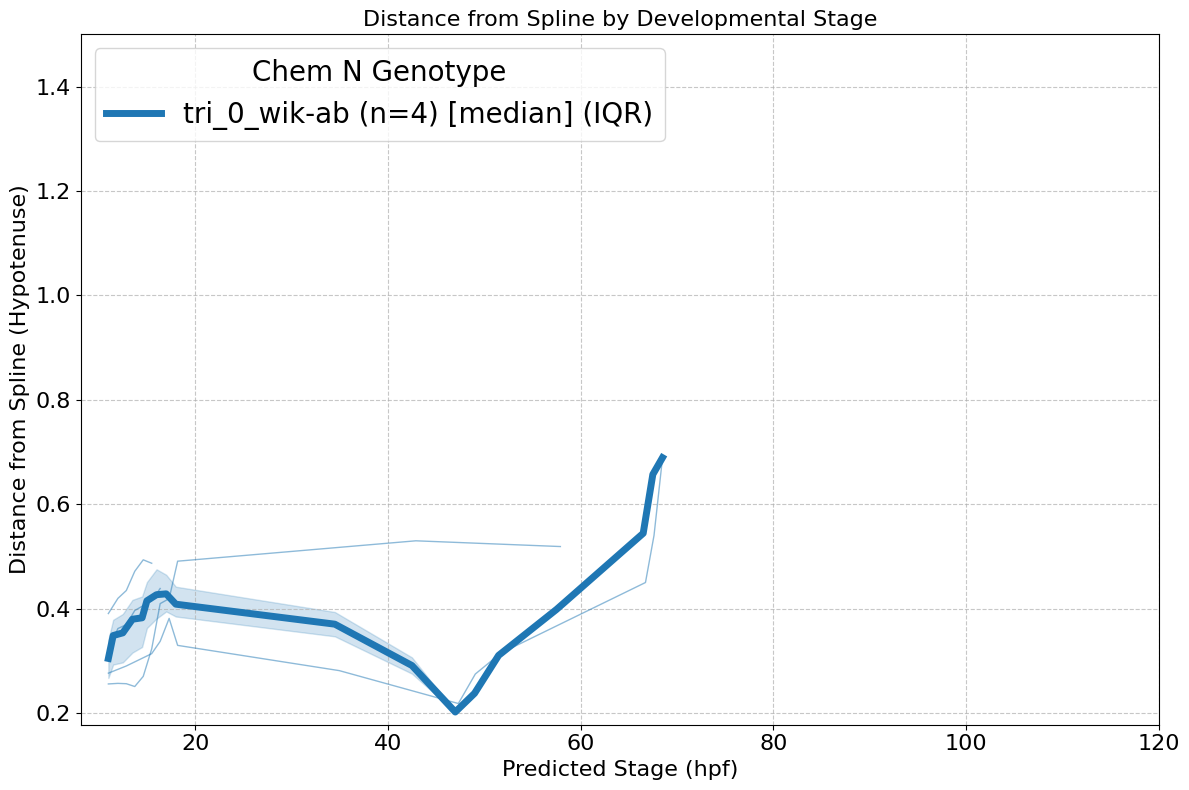

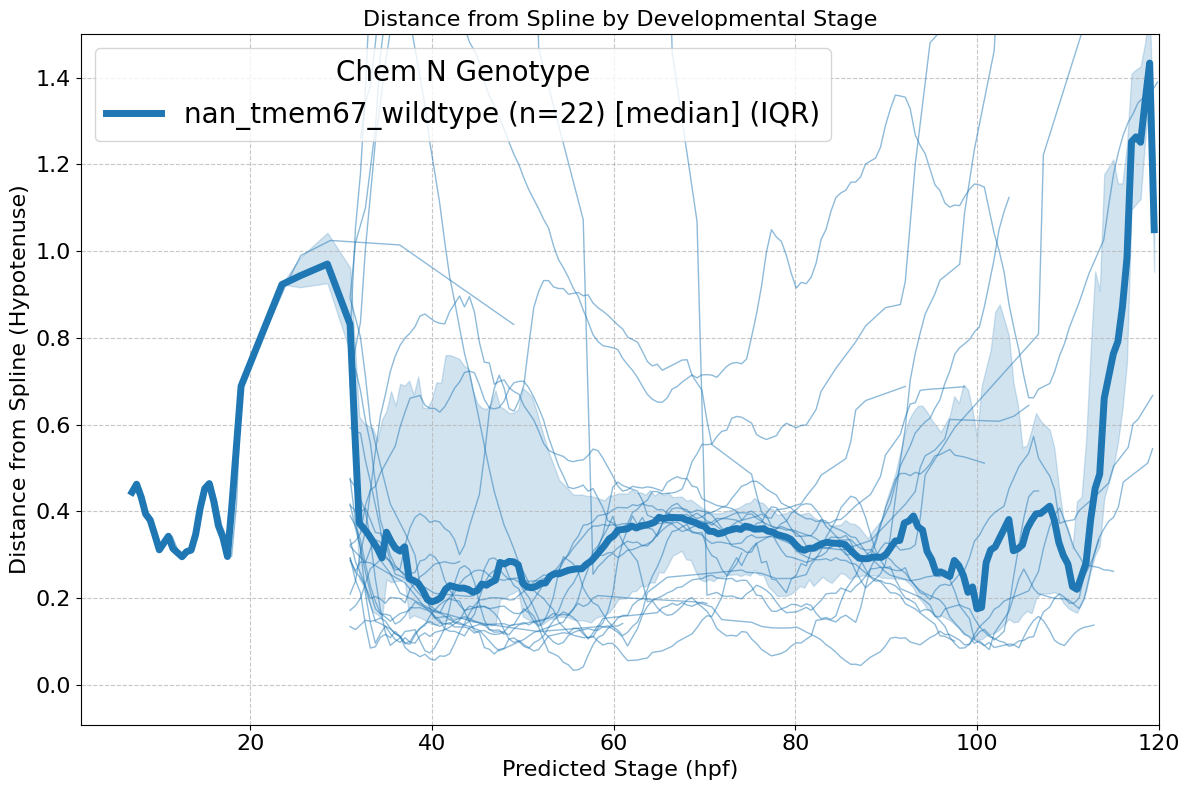

In [65]:

# # Example usage:
target_phenotypes = ['nan_wik', 'tri_1-15_wik-ab', 'tri_1-20_wik-ab', 'tri_1-25_wik-ab',
 'tri_1-30_wik-ab', 'tri_1-35_wik-ab', 'tri_1-40_wik-ab', 'tri_0_wik-ab',
 'nan_tmem67_wildtype'] #+ ['nan_tmem67_heterozygote', 'nan_tmem67_homozygous']



# Line plot with individual embryos and averages
for target in target_phenotypes:

    plot_hypotenuse_over_stage(
        df=df_augmented_projec_wt,
        group_by_col='chem_n_genotype',
        central_tendency='median',
        groups_to_include=[target],
        window_size=5,
        min_hpf=None,
        max_hpf=120,
        plot_variance_bars=True,
        max_distance=1.5,
        # phenotype_colors=cep290_cross_colors,
        title_fontsize=16,
        label_fontsize=16,
        tick_fontsize=16,
        legend_fontsize=20,
        plot_individual_embryos=True,

        # save_path=os.path.join(plot_dir,"hypotenuse_stage_plot_v2.pdf")
    )

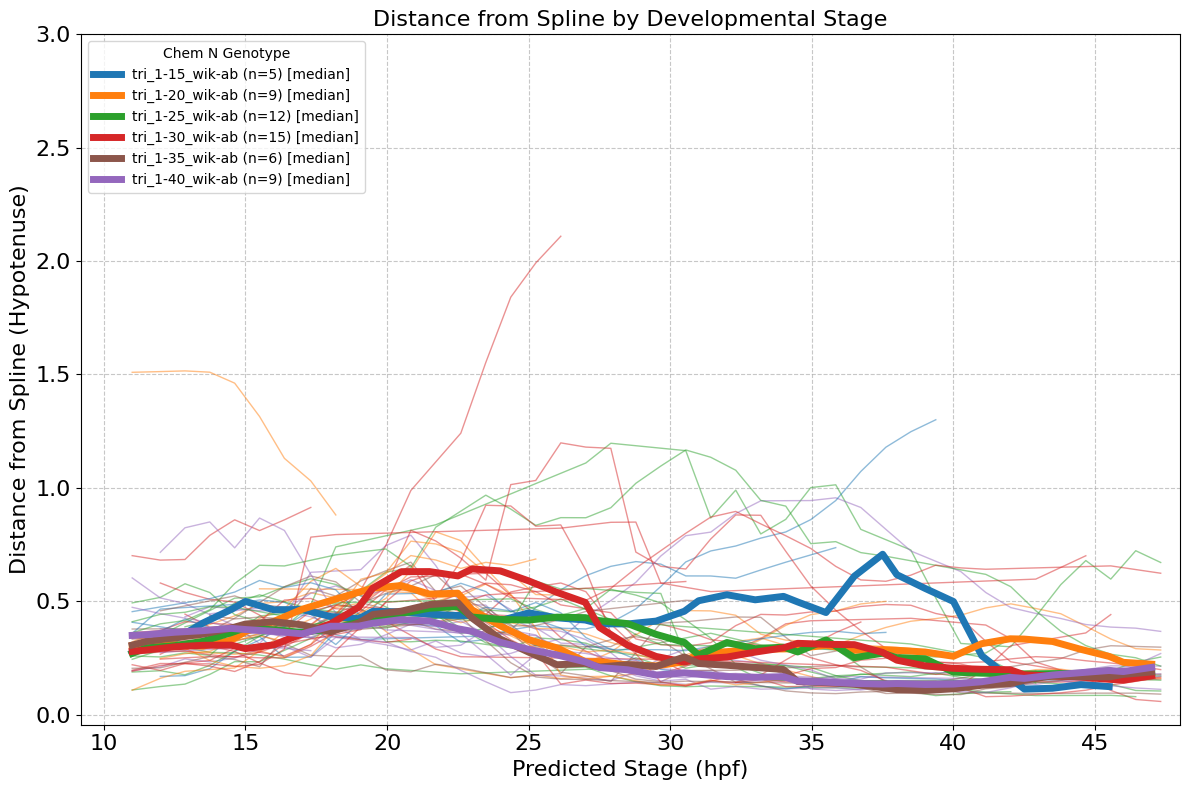

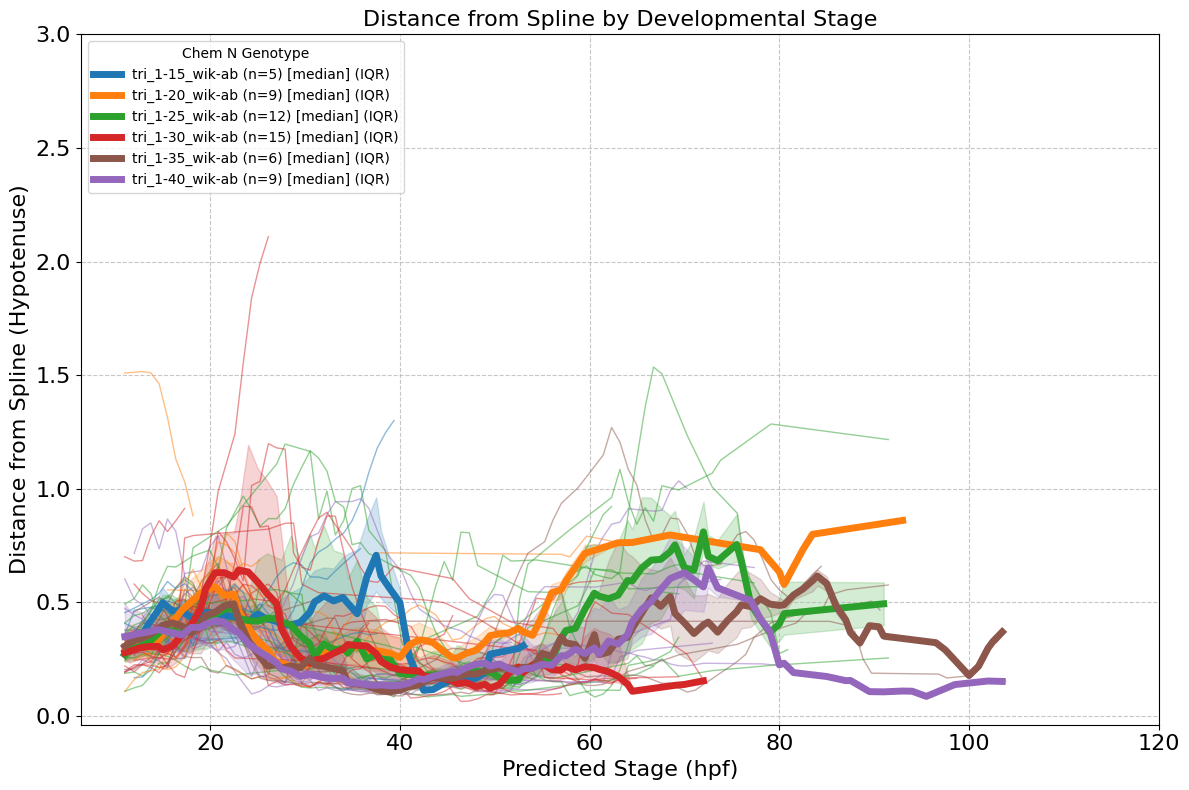

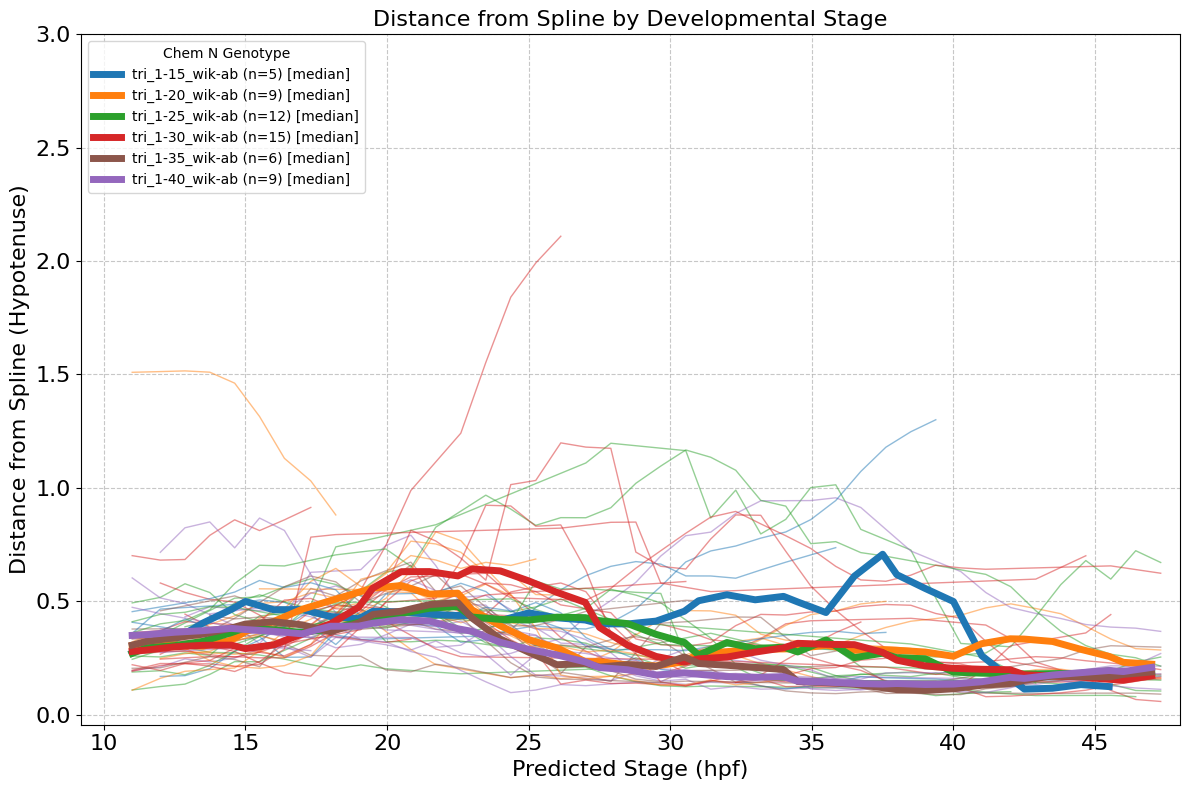

In [66]:

# # Example usage:
target_phenotypes = [ 'tri_1-15_wik-ab', 'tri_1-20_wik-ab', 'tri_1-25_wik-ab',
 'tri_1-30_wik-ab', 'tri_1-35_wik-ab', 'tri_1-40_wik-ab']  #+ [ 'nan_tmem67_wildtype','nan_wik','nan_tmem67_heterozygote', 'nan_tmem67_homozygous']



# Line plot with individual embryos and averages

plot_hypotenuse_over_stage(
    df=df_augmented_projec_wt,
    group_by_col='chem_n_genotype',
    groups_to_include=target_phenotypes,
    window_size=5,
    min_hpf=None,
    max_hpf=120,
    plot_variance_bars=True,
    max_distance=3,
    # phenotype_colors=cep290_cross_colors,
    title_fontsize=16,
    label_fontsize=16,
    tick_fontsize=16,
    legend_fontsize=10,
    plot_individual_embryos=True,
    central_tendency='median',

    # save_path=os.path.join(plot_dir,"titration_experimeint_tri-only_dist_from_spline.pdf")
)


plot_hypotenuse_over_stage(
    df=df_augmented_projec_wt,
    group_by_col='chem_n_genotype',
    groups_to_include=target_phenotypes,
    window_size=5,
    min_hpf=None,
    max_hpf=48,
    plot_variance_bars=False,
    max_distance=3,
    # phenotype_colors=cep290_cross_colors,
    title_fontsize=16,
    label_fontsize=16,
    tick_fontsize=16,
    legend_fontsize=10,
    plot_individual_embryos=True,
    central_tendency='median',

    # save_path=os.path.join(plot_dir,"titration_experimeint_tri-only_dist_from_spline.pdf")
)

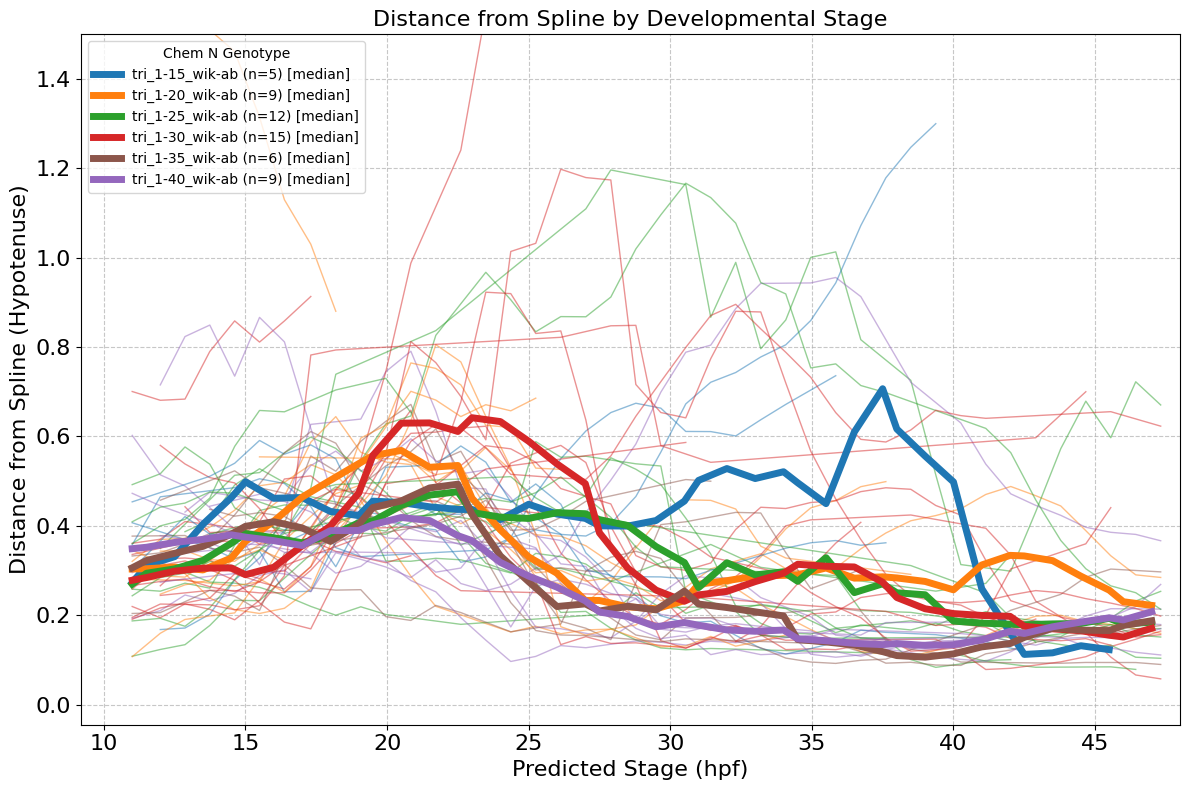

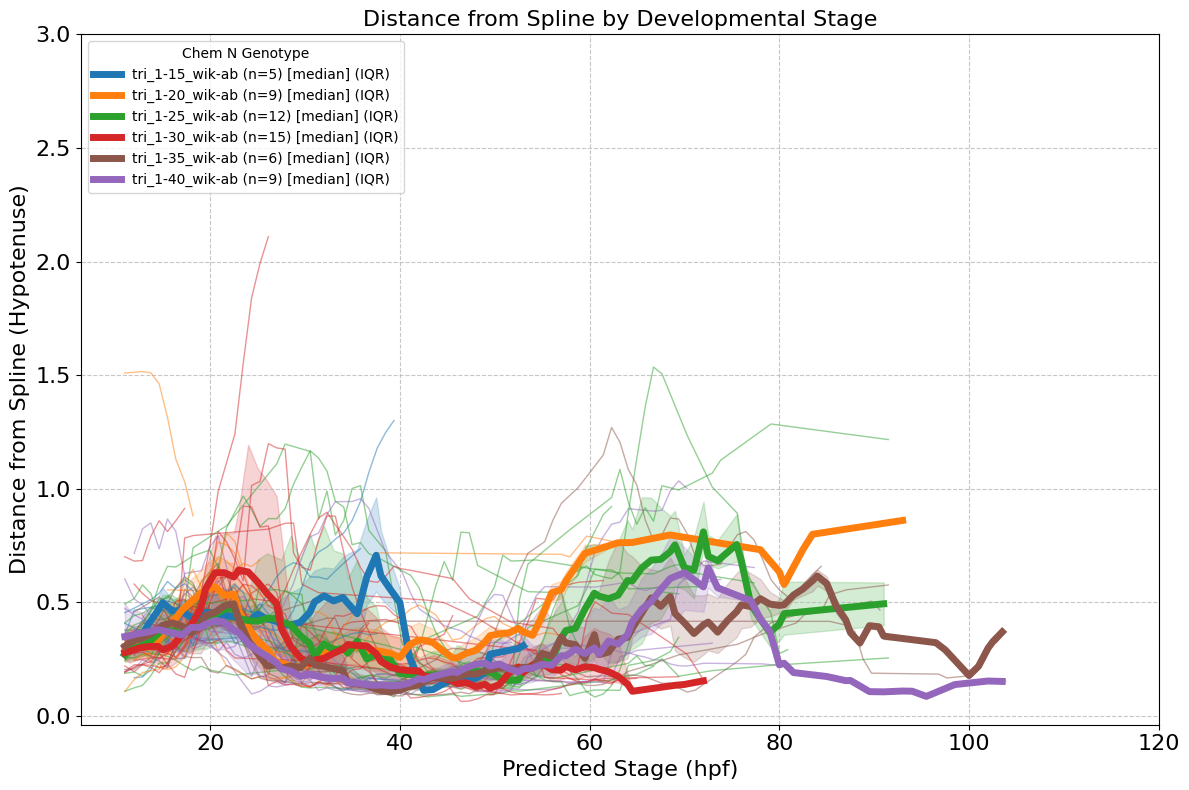

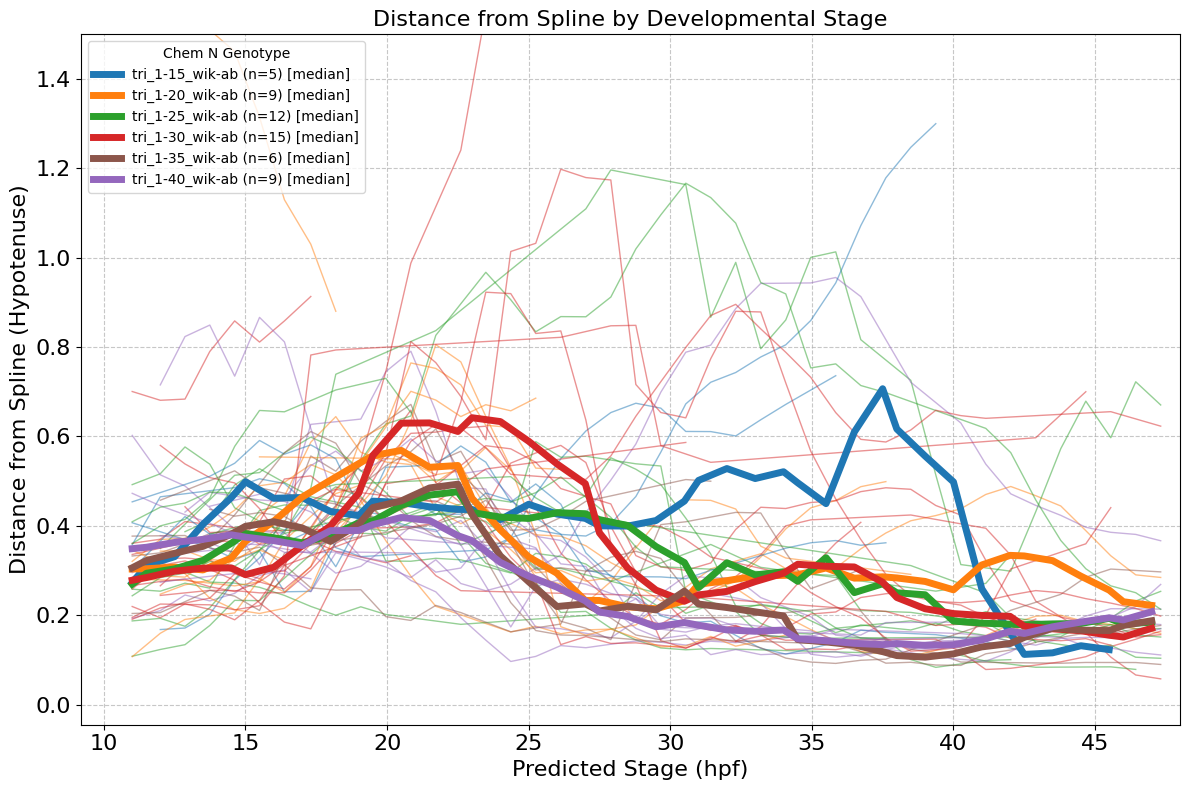

In [67]:

# # Example usage:
target_phenotypes = [ 'tri_1-15_wik-ab', 'tri_1-20_wik-ab', 'tri_1-25_wik-ab',
 'tri_1-30_wik-ab', 'tri_1-35_wik-ab', 'tri_1-40_wik-ab']  #+ [ 'nan_tmem67_wildtype','nan_wik','nan_tmem67_heterozygote', 'nan_tmem67_homozygous']



# Line plot with individual embryos and averages

plot_hypotenuse_over_stage(
    df=df_augmented_projec_wt,
    group_by_col='chem_n_genotype',
    groups_to_include=target_phenotypes,
    window_size=5,
    min_hpf=None,
    max_hpf=120,
    plot_variance_bars=True,
    max_distance=3,
    # phenotype_colors=cep290_cross_colors,
    title_fontsize=16,
    label_fontsize=16,
    tick_fontsize=16,
    legend_fontsize=10,
    plot_individual_embryos=True,
    central_tendency='median',

    # save_path=os.path.join(plot_dir,"titration_experimeint_tri-only_dist_from_spline.pdf")
)


plot_hypotenuse_over_stage(
    df=df_augmented_projec_wt,
    group_by_col='chem_n_genotype',
    groups_to_include=target_phenotypes,
    window_size=5,
    min_hpf=None,
    max_hpf=48,
    plot_variance_bars=False,
    max_distance=1.5,
    # phenotype_colors=cep290_cross_colors,
    title_fontsize=16,
    label_fontsize=16,
    tick_fontsize=16,
    legend_fontsize=10,
    plot_individual_embryos=True,
    central_tendency='median',

    # save_path=os.path.join(plot_dir,"titration_experimeint_tri-only_dist_from_spline.pdf")
)

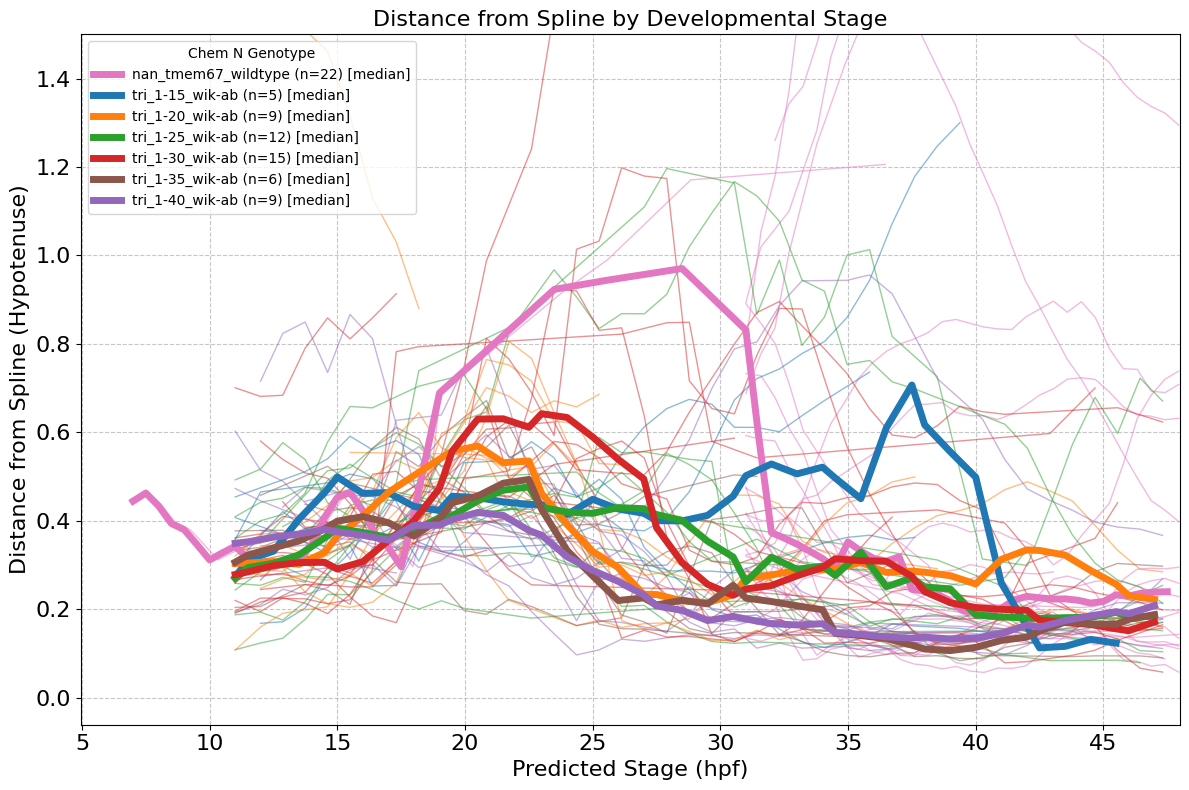

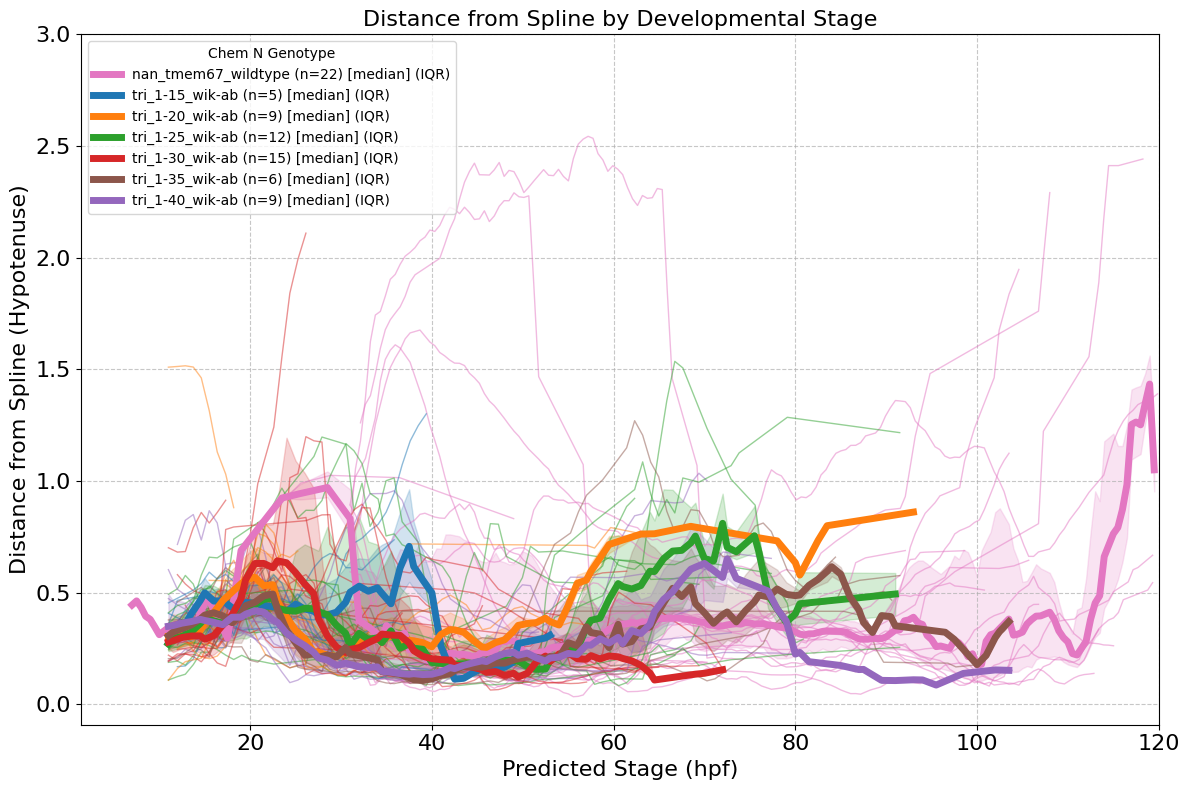

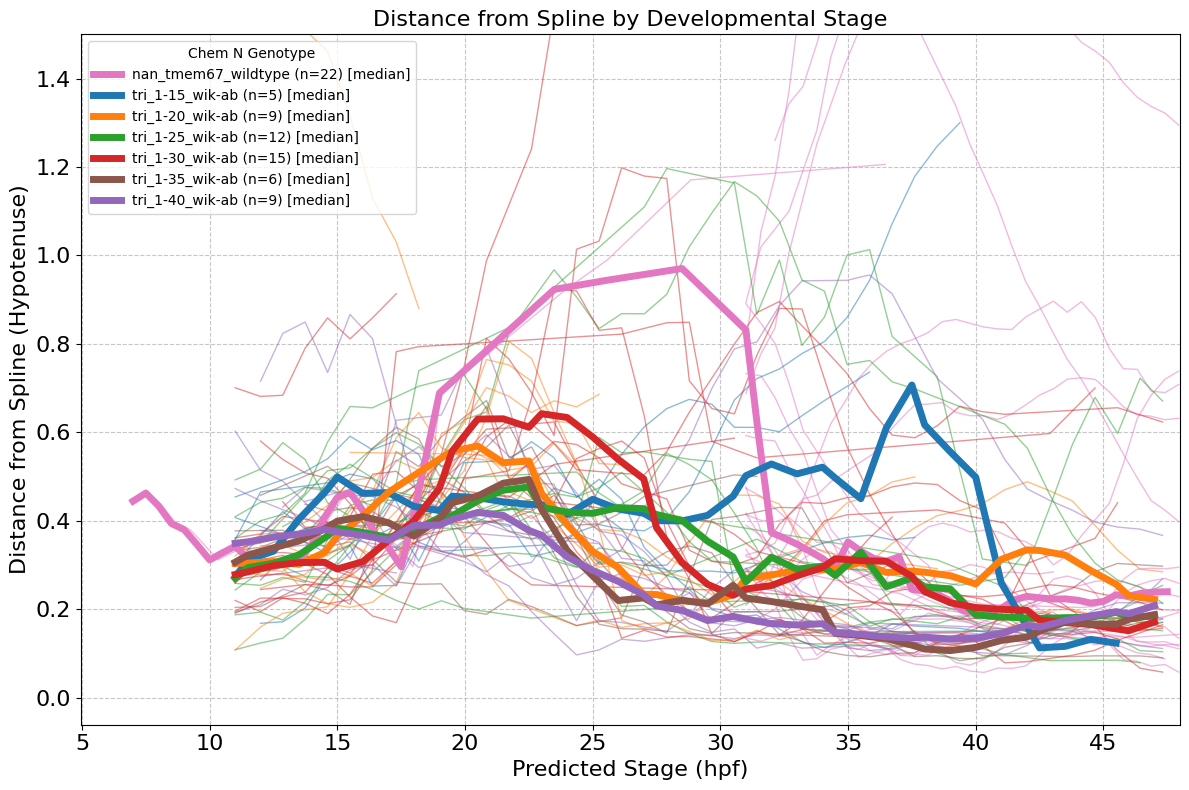

In [68]:

# # Example usage:
target_phenotypes = [ 'tri_1-15_wik-ab', 'tri_1-20_wik-ab', 'tri_1-25_wik-ab',
 'tri_1-30_wik-ab', 'tri_1-35_wik-ab', 'tri_1-40_wik-ab']   + [ 'nan_tmem67_wildtype'] #+ [ 'nan_tmem67_wildtype','nan_wik','nan_tmem67_heterozygote', 'nan_tmem67_homozygous']



# Line plot with individual embryos and averages

plot_hypotenuse_over_stage(
    df=df_augmented_projec_wt,
    group_by_col='chem_n_genotype',
    groups_to_include=target_phenotypes,
    window_size=5,
    min_hpf=None,
    max_hpf=120,
    plot_variance_bars=True,
    max_distance=3,
    # phenotype_colors=cep290_cross_colors,
    title_fontsize=16,
    label_fontsize=16,
    tick_fontsize=16,
    legend_fontsize=10,
    plot_individual_embryos=True,
    central_tendency='median',

    # save_path=os.path.join(plot_dir,"titration_experimeint_tri-only_dist_from_spline.pdf")
)


plot_hypotenuse_over_stage(
    df=df_augmented_projec_wt,
    group_by_col='chem_n_genotype',
    groups_to_include=target_phenotypes,
    window_size=5,
    min_hpf=None,
    max_hpf=48,
    plot_variance_bars=False,
    max_distance=1.5,
    # phenotype_colors=cep290_cross_colors,
    title_fontsize=16,
    label_fontsize=16,
    tick_fontsize=16,
    legend_fontsize=10,
    plot_individual_embryos=True,
    central_tendency='median',

    # save_path=os.path.join(plot_dir,"titration_experimeint_tri-only_dist_from_spline.pdf")
)